# 01wk-2: 딥러닝의 기초 (1) –

최규빈  
2024-03-04

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/01wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-yKD2iq8nJKXMrTG9n_hFBv&si=QUiXul0DWcAYLyyy>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

# 2. 로드맵

`-` 회귀분석 $\to$ 로지스틱 $\to$ 심층신경망(DNN) $\to$
합성곱신경망(CNN)

# 3. ref

`-` 넘파이 문법이 약하다면? (reshape, concatenate, stack)

1.  [reshape](https://guebin.github.io/IP2022/2022/04/06/(6%EC%A3%BC%EC%B0%A8)-4%EC%9B%946%EC%9D%BC.html):
    넘파이공부 2단계 reshape 참고

2.  [concatenate,
    stack](https://guebin.github.io/IP2022/2022/04/11/(6%EC%A3%BC%EC%B0%A8)-4%EC%9B%9411%EC%9D%BC.html):
    아래 링크의 넘파이공부 4단계 참고

# 4. 회귀모형

## A. 모형소개

`-` model:
$y_i= w_0+w_1 x_i +\epsilon_i = 2.5 + 4x_i +\epsilon_i, \quad i=1,2,\dots,n$

`-` model: ${\bf y}={\bf X}{\bf W} +\boldsymbol{\epsilon}$

-   ${\bf y}=\begin{bmatrix} y_1 \\ y_2 \\ \dots \\ y_n\end{bmatrix}, \quad {\bf X}=\begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \dots \\ 1 & x_n\end{bmatrix}, \quad {\bf W}=\begin{bmatrix} 2.5 \\ 4 \end{bmatrix}, \quad \boldsymbol{\epsilon}= \begin{bmatrix} \epsilon_1 \\ \dots \\ \epsilon_n\end{bmatrix}$

## B. 회귀모형에서 데이터 생성

In [2]:
torch.manual_seed(43052)
ones= torch.ones(100)
x,_ = torch.randn(100).sort()
X = torch.stack([ones,x]).T # torch.stack([ones,x],axis=1)
W = torch.tensor([2.5,4])
ϵ = torch.randn(100)*0.5
y = X@W + ϵ

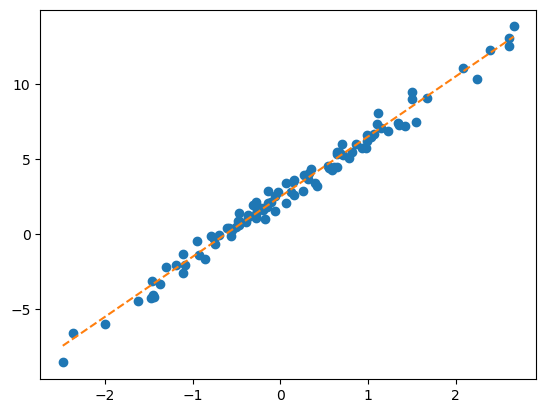

In [3]:
plt.plot(x,y,'o')
plt.plot(x,2.5+4*x,'--')

# 5. 회귀모형에서 학습이란?

`-` 파란점만 주어졌을때, 주황색 점선을 추정하는것. 좀 더 정확하게 말하면
given data로 $\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}$를
최대한 $\begin{bmatrix} 2.5 \\ 4 \end{bmatrix}$와 비슷하게 찾는것.

-   given data : $\big\{(x_i,y_i) \big\}_{i=1}^{n}$

-   parameter: ${\bf W}=\begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$

-   estimated parameter:
    ${\bf \hat{W}}=\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}$

`-` 더 쉽게 말하면 아래의 그림을 보고 `적당한` 추세선을 찾는것이다.

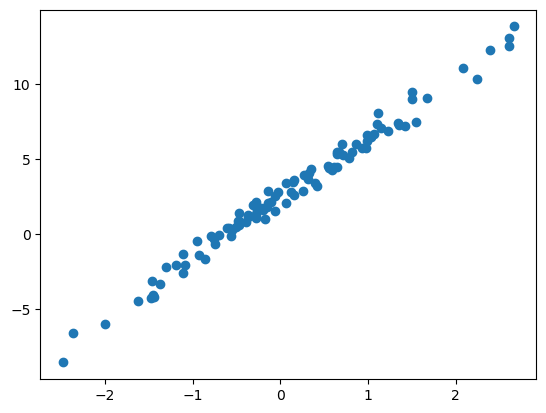

In [4]:
plt.plot(x,y,'o')

`-` 시도: $(\hat{w}_0,\hat{w}_1)=(-5,10)$을 선택하여 선을 그려보고
적당한지 판단.

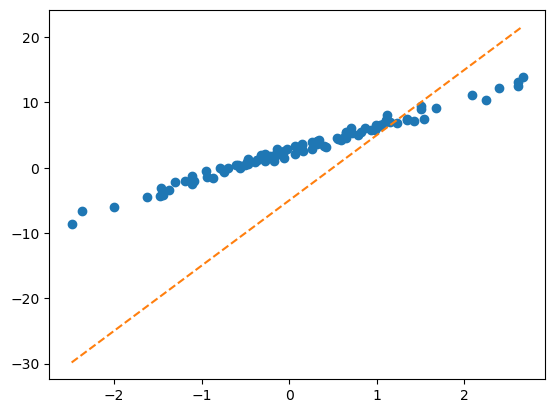

In [5]:
plt.plot(x,y,'o')
plt.plot(x,-5+10*x,'--')

-   $\hat{y}_i=-5 +10 x_i$ 와 같이 $y_i$의 값을 적합시키겠다는 의미

`-` 벡터표현으로 주황색점선을 계산

In [6]:
What = torch.tensor([-5.0,10.0])

In [7]:
X.shape

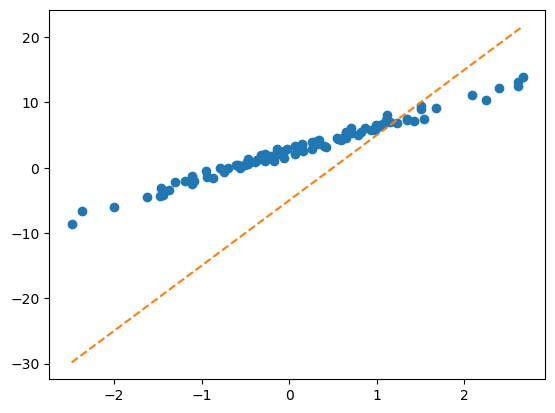

In [8]:
plt.plot(x,y,'o')
plt.plot(x,X@What,'--')

-   이건 일단 망한 학습같음..

# 6. 학습전략

`-` 이론적으로 추론 \<- 회귀분석시간에 배운것

`-` **컴퓨터의 반복계산을 이용하여 추론 (손실함수도입 + 경사하강법)**
\<- 우리가 오늘 파이토치로 실습해볼 내용.

`-` 전략: 아래와 같은 3단계 전략을 취한다.

-   1단계: 아무 점선이나 그어본다..
-   2단계: 1단계에서 그은 점선보다 더 좋은 점선으로 바꾼다.
-   3단계: 1-2단계를 반복한다.

## ***1단계: 아무 점선이나 그어보자..***

`-` $\hat{w}_0=-5, \hat{w}_1 = 10$ 으로 설정하고 (왜? 그냥) 임의의 선을
그어보자.

In [9]:
What = torch.tensor([-5.0,10.0],requires_grad=True)
What

-   처음에는
    ${\bf \hat{W}}=\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}=\begin{bmatrix} -5 \\ 10 \end{bmatrix}$
    를 대입해서 주황색 점선을 적당히 그려보자는 의미

-   끝에 requires_grad=True는 나중에 미분을 위한 것

In [10]:
yhat = X@What 

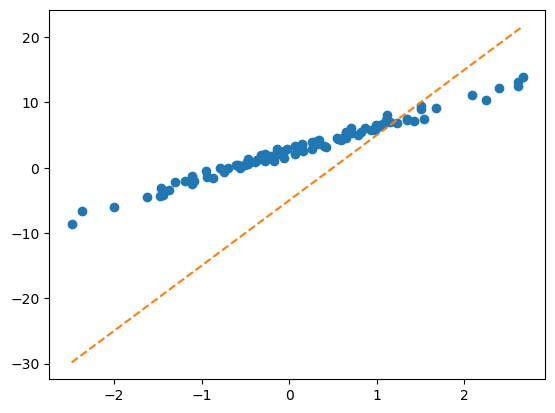

In [11]:
plt.plot(x,y,'o')
plt.plot(x,yhat.data,'--') # 그림을 그리기 위해서 yhat의 미분꼬리표를 제거

## ***2단계: 최초의 점선에 대한 ‘적당한 정도’를 판단하고 더 ’적당한’ 점선으로 업데이트 한다.***

`-` ’적당한 정도’를 판단하기 위한 장치: loss function 도입!

$loss=\sum_{i=1}^{n}(y_i-\hat{y}_i)^2=\sum_{i=1}^{n}(y_i-(\hat{w}_0+\hat{w}_1x_i))^2$

$=({\bf y}-{\bf\hat{y}})^\top({\bf y}-{\bf\hat{y}})=({\bf y}-{\bf X}{\bf \hat{W}})^\top({\bf y}-{\bf X}{\bf \hat{W}})$

`-` loss 함수의 특징

-   $y_i \approx \hat{y}_i$ 일수록 loss값이 작다.
-   $y_i \approx \hat{y}_i$ 이 되도록 $(\hat{w}_0,\hat{w}_1)$을 잘
    찍으면 loss값이 작다.
-   (중요) 주황색 점선이 ‘적당할 수록’ loss값이 작다.

In [12]:
loss = torch.sum((y-yhat)**2)
loss

`-` 우리의 목표: 이 loss(=8587.6875)을 더 줄이자.

-   궁극적으로는 아예모든 조합 $(\hat{w}_0,\hat{w}_1)$에 대하여 가장
    작은 loss를 찾으면 좋겠다. (단계2에서 할일은 아님)

`-` 문제의 치환: 생각해보니까 우리의 문제는 아래와 같이 수학적으로
단순화 되었다.

-   적당해보이는 주황색 선을 찾자 $\to$ $loss(w_0,w_1)$를 최소로하는
    $(w_0,w_1)$의 값을 찾자.

`-` 수정된 목표: $loss(w_0,w_1)$를 최소로 하는 $(w_0,w_1)$을 구하라.

-   단순한 수학문제가 되었다. 마치 $loss(w)=w^2-2w+3$ 을 최소화하는
    $w$를 찾으라는 것과 같음.
-   즉 “적당한 선으로 업데이트 하라 = 파라메터를 학습하라 = 손실함수를
    최소화 하라”

`-` 우리의 무기: 경사하강법, 벡터미분

> **`#` ***경사하강법 복습(?)*****
>
> **경사하강법 아이디어 (1차원)**
>
> (step 1) 임의의 점을 찍는다.
>
> (step 2) 그 점에서 순간기울기를 구한다. (접선) \<– 미분
>
> (step 3) 순간기울기(=미분계수)의 부호를 살펴보고 부호와 반대방향으로
> 움직인다.
>
> (팁) 기울기의 절대값 크기와 비례하여 보폭(=움직이는 정도)을 조절한다.
>
> **경사하강법 아이디어 (2차원)**
>
> (step 1) 임의의 점을 찍는다.
>
> (step 2) 그 점에서 순간기울기를 구한다. (접평면) \<– 편미분
>
> (step 3) 순간기울기(=미분계수)의 부호를 살펴보고 부호와 반대방향으로
> 각각 움직인다.
>
> (팁) 기울기의 절대값 크기와 비례하여 보폭(=움직이는 정도)을 각각
> 조절한다.
>
> **loss를 줄이도록 ${\bf W}$를 개선하는 방법**
>
> `-` \$수정값 원래값 - 기울어진크기(=미분계수) \$
>
> -   여기에서 $\alpha$는 전체적인 보폭의 크기를 결정한다. 즉
>     $\alpha$값이 클수록 한번의 update에 움직이는 양이 크다.
>
> `-`
> ${\bf W} \leftarrow {\bf W} - \alpha \times \frac{\partial}{\partial {\bf W}}loss(w_0,w_1)$
>
> -   마이너스의 의미: 기울기의 부호를 보고 반대방향으로 움직여라.
> -   $\frac{\partial}{\partial {\bf W}}loss(w_0,w_1):$ 기울기의
>     절대값크기와 비례하여 움직이는 정도를 조정하라.
> -   $\alpha$의 의미: 전체적인 보폭의 속도를 조절, $\alpha$가 크면
>     전체적으로 빠르게 움직인다. 다리의 길이로 비유할 수 있다.

`-` 우리의 목표: loss=8587.6875 인데, 이걸 줄이는 것이 목표라고 했었음.
이것을 줄이는 방법이 경사하강법이다.

`-` 경사하강법으로 loss를 줄이기 위해서는
$\frac{\partial}{\partial {\bf W}}loss(w_0,w_1)$의 계산이 필요한데, 이를
위해서 벡터미분이 필요하다. (`loss.backward()`로 하면된다)

In [13]:
loss

In [14]:
loss.backward() 

-   loss.backward()의 의미: loss를 미분해라! 뭘로?
    `requires_grad=True`를 가진 텐서로!!

``` python
loss=torch.sum((y-yhat)**2)= torch.sum((y-X@What)**2)
# 이었고 
What=torch.tensor([-5.0,10.0],requires_grad=True)
# 이므로 결국 What으로 미분하라는 의미. 
# 미분한 식이 나오는 것이 아니고, 
# 그 식에 (-5.0, 10.0)을 대입한 계수값이 계산됨. 
```

`-` 위에서 `loss.backward()`의 과정은 미분을 활용하여 $(-5,10)$에서의
순간기울기를 구했다는 의미임.

`-` (-5,10)에서 loss의 순간기울기 값은 `What.grad`로 확인가능하다.

In [15]:
What,What.grad

-   이것이 의미하는건 $(-5,10)$에서의 $loss(w_0,w_1)$의 순간기울기가
    $(-1342.2522, 1188.9305)$ 이라는 의미

`-` (확인1) `loss.backward()`가 미분을 잘 계산해 주는 것이 맞는가?
손계산으로 검증하여 보자.

-   $loss(w_0,w_1)=({\bf y}-\hat{\bf y})^\top ({\bf y}-\hat{\bf y})=({\bf y}-{\bf XW})^\top ({\bf y}-{\bf XW})$

-   $\frac{\partial}{\partial {\bf W} }loss(w_0,w_1)=-2{\bf X}^\top {\bf y}+2{\bf X}^\top {\bf X W}$

In [16]:
- 2 * X.T @ y + 2 * X.T @ X @ What

In [17]:
# 슬프지만 손계산을 할 수 없다면?..

`-` (확인2) `loss.backward()`가 미분을 잘 계산해 주는 것이 맞는가?
편미분을 간단히 구현하여 검증하여 보자.

-   $\frac{\partial}{\partial {\bf W} } loss(w_0,w_1)=\begin{bmatrix}\frac{\partial}{\partial w_0} \\ \frac{\partial}{\partial w_1} \end{bmatrix}loss(w_0,w_1) =\begin{bmatrix}\frac{\partial}{\partial w_0}loss(w_0,w_1) \\ \frac{\partial}{\partial w_1}loss(w_0,w_1) \end{bmatrix}$

-   $\frac{\partial}{\partial w_0}loss(w_0,w_1) \approx \frac{loss(w_0+h,w_1)-loss(w_0,w_1)}{h}$

-   $\frac{\partial}{\partial w_1}loss(w_0,w_1) \approx \frac{loss(w_0,w_1+h)-loss(w_0,w_1)}{h}$

In [21]:
l = lambda w0,w1: torch.sum((y-w0-w1*x)**2)
l(-5,10)

In [22]:
h=0.001
(l(-5+h,10) - l(-5,10))/h,  (l(-5,10+h) - l(-5,10))/h

-   약간 오차가 있지만 얼추비슷 $\to$ 잘 계산했다는 소리임

`-` 수정전, 수정하는폭, 수정후의 값은 차례로 아래와 같다.

In [25]:
alpha=0.001 
print(f'수정전: {What.data}') # What 에서 미분꼬리표를 떼고 싶다면? What.data or What.detach()
print(f'수정하는폭: {-alpha * What.grad}')
print(f'수정후: {What.data-alpha * What.grad}')
print(f'*참값: (2.5,4)' )

수정전: tensor([-5., 10.])
수정하는폭: tensor([ 1.3423, -1.1889])
수정후: tensor([-3.6577,  8.8111])
*참값: (2.5,4)

`-` Wbefore, Wafter 계산

In [26]:
Wbefore = What.data
Wafter = What.data - alpha * What.grad
Wbefore, Wafter

`-` Wbefore, Wafter의 시각화

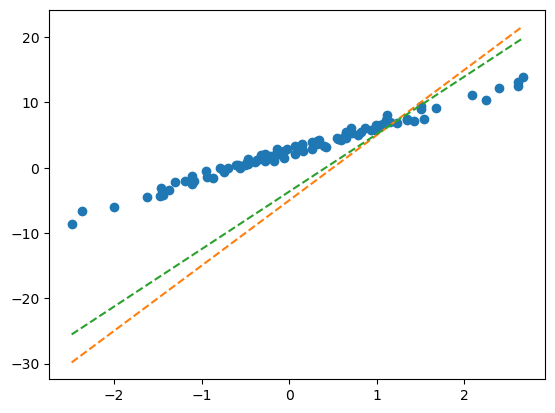

In [27]:
plt.plot(x,y,'o')
plt.plot(x,X@Wbefore,'--')
plt.plot(x,X@Wafter,'--')

## ***3단계: Learn (=estimate $\bf\hat{W})$***

`-` 이 과정은 단계1-2를 반복하면 된다.

In [28]:
What= torch.tensor([-5.0,10.0],requires_grad=True) #

In [29]:
alpha=0.001 
for epoc in range(30): ## 30번 반복합니다!! 
    yhat=X@What 
    loss=torch.sum((y-yhat)**2)
    loss.backward() 
    What.data = What.data-alpha * What.grad
    What.grad=None

-   원래 철자는 epoch이 맞아요

`-` 반복결과는?! (최종적으로 구해지는 What의 값은?!) - 참고로 true

In [30]:
What.data ## true인 (2.5,4)와 상당히 비슷함

`-` 반복결과를 시각화하면?

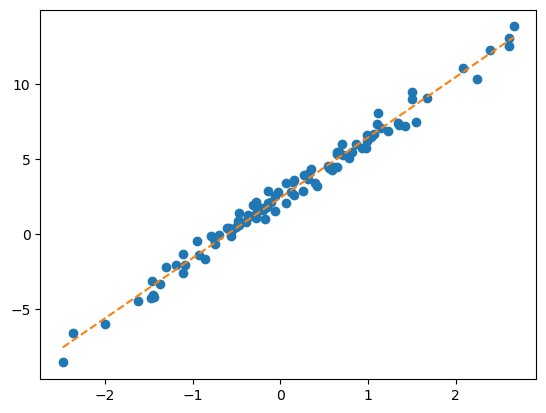

In [31]:
plt.plot(x,y,'o')
plt.plot(x,X@What.data,'--')

# 7. 숙제

`-` 뭐 할까? ㅎㅎ